# Estimating Zernikes with WEP

Owner: **Bryce Kalmbach** ([@jbkalmbach](https://github.com/lsst-ts/ts_analysis_notebooks/issues/new?body=@jbkalmbach))
<br>Last Verified to Run: **2022-02-14**
<br>Software Versions:
  - `ts_wep`: **v2.2.0**
  - `lsst_distrib`: **w_2022_06**

## Notebook Objective

This notebooks shows how to calculate the Zernike coefficients for a detector using `EstimateZernikesCwfsTask`. It walks through the available configuration settings and shows how to run it from the command line as part of a Gen 3 middleware pipeline.

## Logistics

This notebook is intended to be run on the RSP https://lsst-rsp-stable.ncsa.illinois.edu/nb. The data set is on NCSA.

## Imports

In [1]:
from lsst.daf.butler import Butler

from lsst.ts.wep.Utility import runProgram, writePipetaskCmd
from lsst.ts.wep.task.EstimateZernikesCwfsTask import EstimateZernikesCwfsTask, EstimateZernikesCwfsTaskConfig

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## EstimateZernikes

With the catalogs for each chip and the postISRCCD exposures we can run the next task in the pipeline to get the Zernikes.

### Configure the `EstimateZernikes...Task`

Here we will look at the available configuration settings when running the task.

In [2]:
zernConfig = EstimateZernikesCwfsTaskConfig()

In [3]:
print(zernConfig)

{'saveMetadata': True, 'saveLogOutput': True, 'donutTemplateSize': 160, 'donutStampSize': 160, 'initialCutoutPadding': 40, 'combineZernikes': {'sigma': 3.0}, 'connections': {'donutCatalog': 'donutCatalog', 'camera': 'camera', 'donutStampsExtra': 'donutStampsExtra', 'donutStampsIntra': 'donutStampsIntra', 'outputZernikesRaw': 'zernikeEstimateRaw', 'outputZernikesAvg': 'zernikeEstimateAvg', 'exposures': 'postISRCCD'}}


#### Available Configuration settings

* `donutTemplateSize`: Size in pixels of template used for centroiding the donuts. Default=160.
* `donutStampSize`: Size of the donut stamps in pixels. Default=160.
* `initialCutoutPadding`: Additional padding in pixels on each side of the initial postage stamp before centroiding. Default=40.
* `combineZernikes`: This setting specifies which `CombineZernikes` subtask to use when combining the Zernike coefficients from donut pairs to return a single set of Zernike coefficients for a detector. Available options are `CombineZernikesMeanTask` (combines coefficients with an unweighted mean) and `CombineZernikesSigmaClipTask` (calculates unweighted mean after masking out donuts that have any Zernike coefficients more than `sigma` standard deviations outside the mean value of all donuts. The default subtask is `CombineZernikesSigmaClipTask` and the default value for `combineZernikes.sigma` is 3.0.

#### Changing Configuration Settings in Interactive Mode

To change one of the configuration settings that only involves a number it is as easy as:

In [4]:
print(zernConfig.initialCutoutPadding)

40


In [5]:
zernConfig.initialCutoutPadding = 10
print(zernConfig.initialCutoutPadding)

10


This is also true to change the settings inside the `combineZernikes` subtask:

In [6]:
print(zernConfig.combineZernikes.sigma)

3.0


In [7]:
zernConfig.combineZernikes.sigma = 2.0
print(zernConfig.combineZernikes.sigma)

2.0


But to change the subtask that `combineZernikes` uses you need to use the `retarget` function:

In [8]:
print(zernConfig.combineZernikes.target)

<class 'lsst.ts.wep.task.CombineZernikesSigmaClipTask.CombineZernikesSigmaClipTask'>


In [9]:
from lsst.ts.wep.task.CombineZernikesMeanTask import CombineZernikesMeanTask
zernConfig.combineZernikes.retarget(CombineZernikesMeanTask)
print(zernConfig.combineZernikes.target)

<class 'lsst.ts.wep.task.CombineZernikesMeanTask.CombineZernikesMeanTask'>


### Running the task

Now we can run the task with our set configurations. The data we need to run the `EstimateZernikesCwfsTask` are the `postISR` exposures from a pair of corner wavefront sensors and the `donutCatalog` for the visit on those detectors as well as a calibration model for the `camera`.

In [10]:
# Initiate the task with our given configuration
zernTask = EstimateZernikesCwfsTask(config=zernConfig)

In [11]:
# Repository with closed loop data
butler_repo = '/project/aos/data_repos/aosTestDataRepo'
# Initialize the butler to get the donut catalogs and postISR exposures
butler = Butler(butler_repo)
registry = butler.registry

In [12]:
# Specify the data Ids for the data in the repository
dataIdExtra = {'instrument': 'LSSTCam', 'detector': 191, 'exposure': 4021123110021, 'visit': 4021123110021}
dataIdIntra = {'instrument': 'LSSTCam', 'detector': 192, 'exposure': 4021123110021, 'visit': 4021123110021}

In [13]:
# Load the donut catalogs
donutCatalogExtra = butler.get('donutCatalog', dataId=dataIdExtra, collections=['w_2022_06'])
donutCatalogIntra = butler.get('donutCatalog', dataId=dataIdIntra, collections=['w_2022_06'])

In [14]:
# Load the postISR exposures
isrOutExtra = butler.get('postISRCCD', dataId=dataIdExtra, collections=['w_2022_06'])
isrOutIntra = butler.get('postISRCCD', dataId=dataIdIntra, collections=['w_2022_06'])

In [15]:
# Get the camera model
camera = butler.get('camera', {'instrument': 'LSSTCam'}, collections=['LSSTCam/calib/unbounded'])

In [16]:
# Run the Zernike estimation task
zernOutput = zernTask.run(
    [isrOutExtra, isrOutIntra],
    [donutCatalogExtra, donutCatalogIntra],
    camera
)

scalars={'numDonutsTotal': 3, 'numDonutsUsed': 3.0, 'numDonutsRejected': 0.0} arrays={'combineZernikesFlags': [0.0, 0.0, 0.0]} metadata={}


Note that the `combineZernike` task will print out log information for the user.

In [17]:
zernOutput

Struct(outputZernikesAvg=[-0.65817198  0.67749956  0.42454741 -0.12388158  0.31833513 -0.08849994
 -0.33968782  0.01215916  0.01098545 -0.04837799 -0.06583297  0.02398053
 -0.07421616  0.07897657 -0.01796492 -0.00080373  0.11869624 -0.05629749
  0.00582783]; outputZernikesRaw=[[-6.50162390e-01  3.79885575e-01  4.17168883e-01 -7.06500364e-02
   3.17994448e-01 -9.45840512e-02 -2.89673728e-01 -9.71983088e-03
   1.00831136e-02 -6.58564907e-03 -1.07646839e-01 -2.81159326e-03
  -8.75926948e-02  5.35233937e-02 -2.25267497e-02 -1.53258386e-02
   8.60051809e-02 -5.17570982e-02  1.39626134e-02]
 [-6.41889028e-01  8.41607235e-01  2.40559265e-01 -2.08612980e-01
   2.86322626e-01 -1.33768211e-02 -3.00058689e-01  2.03275949e-02
   2.36255200e-02 -5.67112400e-02 -3.63062800e-02 -9.20105716e-02
  -6.02349176e-02  1.04836353e-01 -1.12267730e-02 -3.91448133e-03
   1.06310571e-01 -2.20972266e-03  3.93703684e-03]
 [-6.82464525e-01  8.11005880e-01  6.15914086e-01 -9.23817096e-02
   3.50688325e-01 -1.575389

The final output of the task is a `struct` with four different datasets:

* `outputZernikesRaw`: This contains the Zernike cofficients for all donuts selected on the detector, one set of coefficients per row.
* `outputZernikesAvg`: This is the array with combined set of Zernike coefficients that is the output from whichever `combineZernikes` task was selected and the `outputZernikesRaw`.
* `donutStampsExtra`: This is a `donutStamps` object that contains postage stamps and location information of the extra-focal donuts selected for use in the Zernike estimation.
* `donutStampsIntra`: This is a `donutStamps` object that contains postage stamps and location information of the intra-focal donuts selected for use in the Zernike estimation.

Here we can plot the output Zernikes cofficients for each pair of donuts and the combined value.

Text(0, 0.5, 'Zernike Coefficient (microns)')

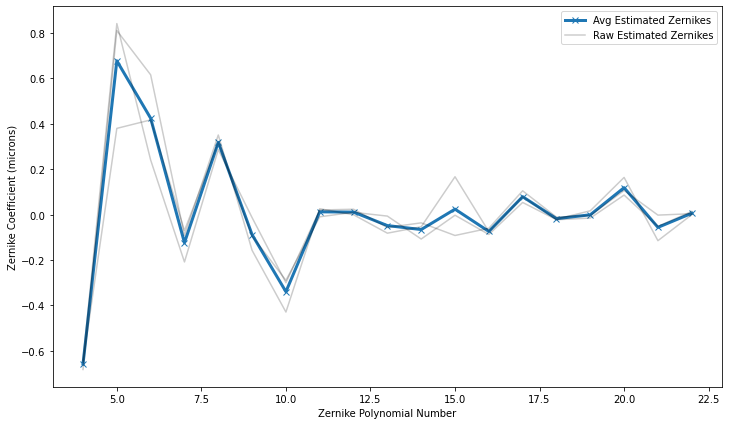

In [18]:
fig = plt.figure(figsize=(12,7))
plt.plot(np.arange(4,23), zernOutput.outputZernikesAvg, '-x', lw=3, label='Avg Estimated Zernikes')
plt.plot(np.arange(4,23), zernOutput.outputZernikesRaw[0], c='k', alpha=0.2, label='Raw Estimated Zernikes')
for i in range(1, 3):
    plt.plot(np.arange(4,23), zernOutput.outputZernikesRaw[i], c='k', alpha=0.2)
plt.legend()
plt.xlabel('Zernike Polynomial Number')
plt.ylabel('Zernike Coefficient (microns)')

The task also maintains the metadata on the number of donuts used in the final Zernike estimate and which donuts were kept and rejected.

In [19]:
zernTask.combineZernikes.metadata

TaskMetadata(scalars={'numDonutsTotal': 3, 'numDonutsUsed': 3.0, 'numDonutsRejected': 0.0}, arrays={'combineZernikesFlags': [0.0, 0.0, 0.0]}, metadata={})

### Running as a pipeline task

Here in this example notebook we showed how to run the `EstimateZernikesCWFSTask` in individual steps. When running in a full Gen3 processing pipeline you can use `EstimateZernikesCWFSTask` setting the configuration settings for source selection in a pipeline file or on the command line.

If you have `raw` data and have not yet run the `isrTask` or `generateDonutCatalogWCSTask` you can run a full pipeline with the following configuration file:

```
# This yaml file is used to define the tasks and configuration of
# a Gen 3 pipeline to run donut source selection using ts_wep
description: wep sample source selection pipeline
# Here we specify the corresponding instrument for the data we
# will be using.
instrument: lsst.obs.lsst.LsstCam
# Then we can specify each task in our pipeline by a name
# and then specify the class name corresponding to that task
tasks:
  isr:
    class: lsst.ip.isr.isrTask.IsrTask
    # Below we specify the configuration settings we want to use
    # when running the task in this pipeline. Since our data doesn't
    # include bias or flats we only want to use doApplyGains and
    # doOverscan in our isr task.
    config:
      connections.outputExposure: 'postISRCCD'
      doBias: False
      doVariance: False
      doLinearize: False
      doCrosstalk: False
      doDefect: False
      doNanMasking: False
      doInterpolate: False
      doBrighterFatter: False
      doDark: False
      doFlat: False
      doApplyGains: True
      doFringe: False
      doOverscan: True
  generateDonutCatalogWcsTask:
    class: lsst.ts.wep.task.GenerateDonutCatalogWcsTask.GenerateDonutCatalogWcsTask
    # Here we specify the configurations for pointing that we added into the class
    # GenerateDonutCatalogWcsTaskConfig.
    config:
      connections.refCatalogs: 'ps1_pv3_3pi_20170110'
      filterName: 'g'
      referenceSelector.doMagLimit: True
      referenceSelector.magLimit.maximum: 15.90
      referenceSelector.magLimit.minimum: 8.74
      referenceSelector.magLimit.fluxField: 'g_flux'
      doDonutSelection: True
      donutSelector.fluxField: 'g_flux'
  estimateZernikesCwfsTask:
    class: lsst.ts.wep.task.EstimateZernikesCwfsTask.EstimateZernikesCwfsTask
    config:
      # And here we specify the configuration settings originally defined in
      # EstimateZernikesCwfsTaskConfig.
      donutTemplateSize: 160
      donutStampSize: 160
      initialCutoutPadding: 40
```

And a possible entry on the command line would be:

`pipetask run -b $PATH_TO_BUTLER_REPO -i $COLLECTION_NAMES -d "exposure in ($EXPOSURE_IDS)" -p $PIPELINE_CONFIGURATION_FILE --instrument lsst.obs.lsst.LsstCam  --register-dataset-types --output-run $OUTPUT_RUN_NAME `

* `-b` points to your repository
* `-i` names the collections where your calibration and raw data are located in the repository
* `-d` specify a data selection query here
* `-p` the path to the configuration file like the sample above
* `--instrument` specify the instrument for your data
* `--register-dataset-types` registers any dataset types that don't already exist in the registry
* `--output-run` specifies the name of the new output collection